In [76]:
%load_ext autoreload
%autoreload 2

##  we're using the following packages (see requirements.txt for more):

#   msapy == 1.1.0
#   netneurotools (unclear version but the branch is merged on Oct 5, 2022)
#   numpy == 1.20.3
#   numba == 0.56.4
#   pandas == 1.3.5 ##### make sure it's not 1.5 otherwise somehow the causal influence matrices shift and we still don't know why because the tests all pass with both versions!
#   bctpy == 0.6.0
#   networkx == 3.0

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[autoreload of utils failed: Traceback (most recent call last):
  File "/home/kayson/anaconda3/envs/communicability/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 261, in check
    superreload(m, reload, self.old_objects)
  File "/home/kayson/anaconda3/envs/communicability/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 459, in superreload
    module = reload(module)
  File "/home/kayson/anaconda3/envs/communicability/lib/python3.9/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 613, in _exec
  File "<frozen importlib._bootstrap_external>", line 846, in exec_module
  File "<frozen importlib._bootstrap_external>", line 983, in get_code
  File "<frozen importlib._bootstrap_external>", line 913, in source_to_code
  File "<frozen importlib._bootstrap>", line 228, in _call_with_frames_removed
  File "/home/kayson/ownCloud/communication-and-causation/utils.py", line 65
    def

In [77]:
import numpy as np
from msapy import msa, plottings as pl
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
import utils as ut
from copy import deepcopy
import pandas as pd
from numba import njit
import netneurotools.datasets
from netneurotools.networks import threshold_network
from netneurotools.metrics import communicability_wei, communicability_bin
from netneurotools.plotting import plot_fsaverage
import warnings

from mayavi import mlab


In [78]:
SEED = 2023
pl.set_style(font_size=8)
my_colors = ['#006685', '#3FA5C4', '#FFFFFF', '#E84653', '#BF003F']
my_reds = ['#FFFFFF', '#E84653', '#BF003F']
my_blues = ['#FFFFFF', '#3FA5C4', '#006685']
colormap = sns.blend_palette(my_colors,as_cmap=True)
redmap = sns.blend_palette(my_reds,as_cmap=True)
bluemap = sns.blend_palette(my_blues,as_cmap=True)

sagittal=(0, 180)
axial=(90, 180)
coronal=(0, 90)
bottom=(-90,0)

In [79]:
@njit
def simple_dynamical_system(adjacency_matrix,input_matrix):
    X = np.zeros((input_matrix.shape[0], input_matrix.shape[1]))

    for timepoint in range(input_matrix.shape[1] - 1):
        X[:, timepoint + 1] = np.tanh(adjacency_matrix @ X[:, timepoint] + input_matrix[:,timepoint])

    return X

@njit
def simple_linear_dynamical_system(adjacency_matrix,input_matrix):
    X = np.zeros((input_matrix.shape[0], input_matrix.shape[1]))

    for timepoint in range(input_matrix.shape[1] - 1):
        X[:, timepoint + 1] = adjacency_matrix @ X[:, timepoint] + input_matrix[:,timepoint]

    return X

def find_density(connectivity):
    return np.where(connectivity!=0,1,0).sum()/connectivity.shape[0]**2

def normer(x):
    return (x - x.min()) / (x.max() - x.min())

def spectral_normalization(target_radius,connectivity):
    return connectivity * target_radius/(np.max(np.abs(np.linalg.eigvals(connectivity))))

def threshold(lower_threshold,connectivity):
    connectivity = pd.DataFrame(connectivity)
    connectivity = connectivity.fillna(0)
    lower = np.percentile(connectivity, lower_threshold)
    upper = np.percentile(connectivity, 100-lower_threshold)
    connectivity[(connectivity < upper) & (connectivity > lower)] = 0.
    return connectivity

def event_maker(n_units, timesteps,probability=1):
    if probability < 1:
        input = rng.choice([0,1],p=[1-probability,probability],size=(n_units,timesteps))
        input = input.astype(float)
    else:
        input = np.zeros((n_units,timesteps))
        for node in range(n_units):
            event_timepoints = rng.integers(0,timesteps,1)
            input[node,event_timepoints] += 1
    
    return input

def brain_plotter(data,coordinates,axis,view=(90,180),size=20,cmap='viridis',scatter_kwargs=None):

    axis.scatter(coordinates[:,0],coordinates[:,1],coordinates[:,2],c=data,cmap=cmap,s=size,**scatter_kwargs)
    axis.view_init(*view)
    axis.axis('off')
    scaling = np.array([axis.get_xlim(),
                    axis.get_ylim(),
                    axis.get_zlim()])
    axis.set_box_aspect(tuple(scaling[:, 1]/2 - scaling[:, 0]))
    return axis

def make_influence_ratio(difference_matrix,axis=0):
    positives=(difference_matrix>0).sum(axis)/len(difference_matrix)
    negatives=(difference_matrix<0).sum(axis)/len(difference_matrix)
    return(positives-negatives)

def check_symmetric(a, tol=1e-8):
    return np.all(np.abs(a-a.T) < tol)

In [80]:
def lesion_simple_nodes(complements, network, index,input,model = simple_linear_dynamical_system, model_kwargs = None):

    lesioned_network = deepcopy(network)
    for target in complements:
        lesioned_network[:,target] = 0.0
        lesioned_network[target,:] = 0.0
    model_kwargs = model_kwargs if model_kwargs else {}
    
    dynamics = model(lesioned_network,input,**model_kwargs)
    lesioned_signal = dynamics[index]
    return lesioned_signal

In [81]:
rng = np.random.default_rng(seed=SEED)
chain = nx.to_numpy_array(nx.generators.path_graph(6,nx.DiGraph())).T


closedchain = chain.copy()
closedchain[0,5]=1
closedchain = spectral_normalization(0.9,closedchain)

chain *= 0.9

symmetricchain = nx.to_numpy_array(nx.generators.path_graph(6))
symmetricchain = spectral_normalization(0.9,symmetricchain)

timesteps = 100
example_input = event_maker(6,timesteps)
#example_input = rng.normal(0,1,(6,timesteps))

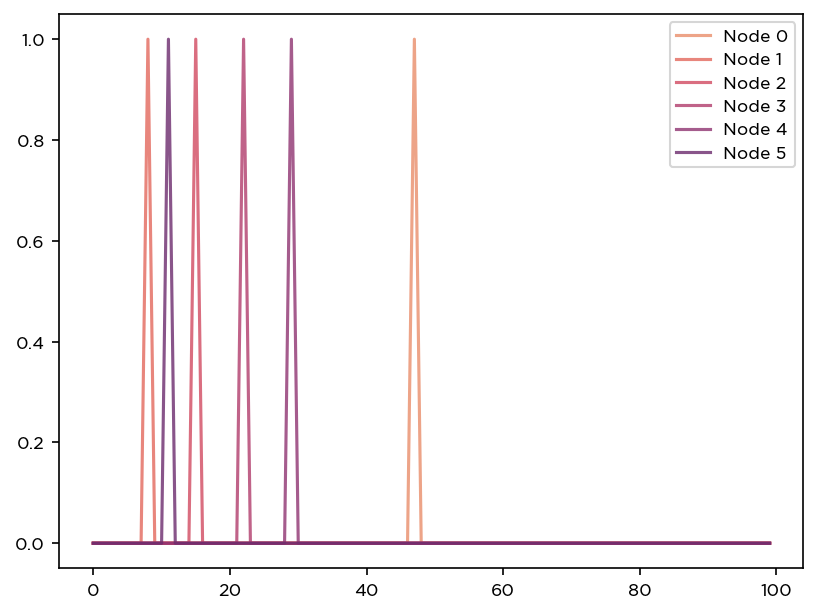

In [82]:
plt.figure(dpi=150)
with sns.color_palette("flare",n_colors=example_input.shape[0]):
    plt.plot(example_input.T,alpha=0.8)
plt.legend(['Node 0','Node 1','Node 2','Node 3','Node 4','Node 5']);

In [83]:
warnings.filterwarnings("ignore")
simple_chain_dynamics = simple_linear_dynamical_system(chain,example_input)
closed_chain_dynamics = simple_linear_dynamical_system(closedchain,example_input)
symmetric_chain_dynamics = simple_linear_dynamical_system(symmetricchain,example_input)

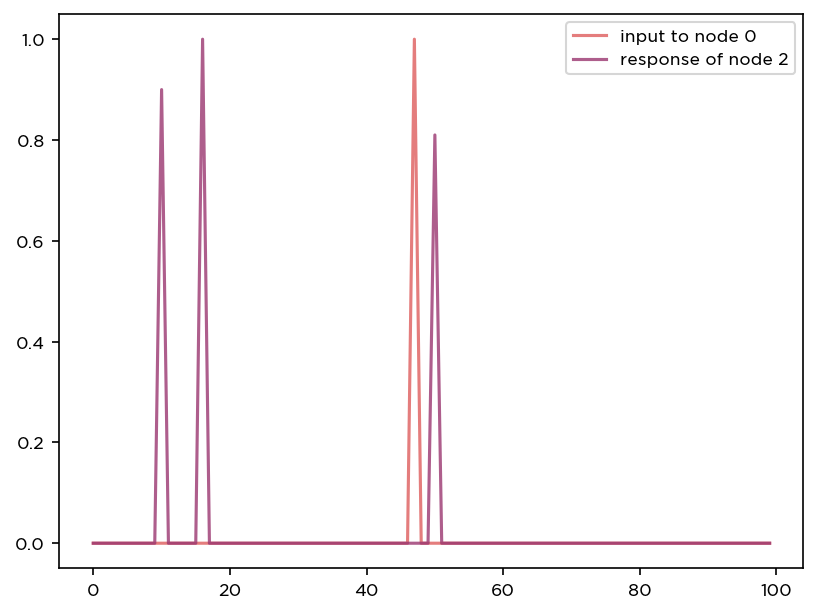

In [84]:
plt.figure(dpi=150)
with sns.color_palette("flare",n_colors=2):
    plt.plot(example_input[0],alpha=0.8)
    plt.plot(simple_chain_dynamics[2],alpha=0.8)

plt.legend(['input to node 0','response of node 2']);


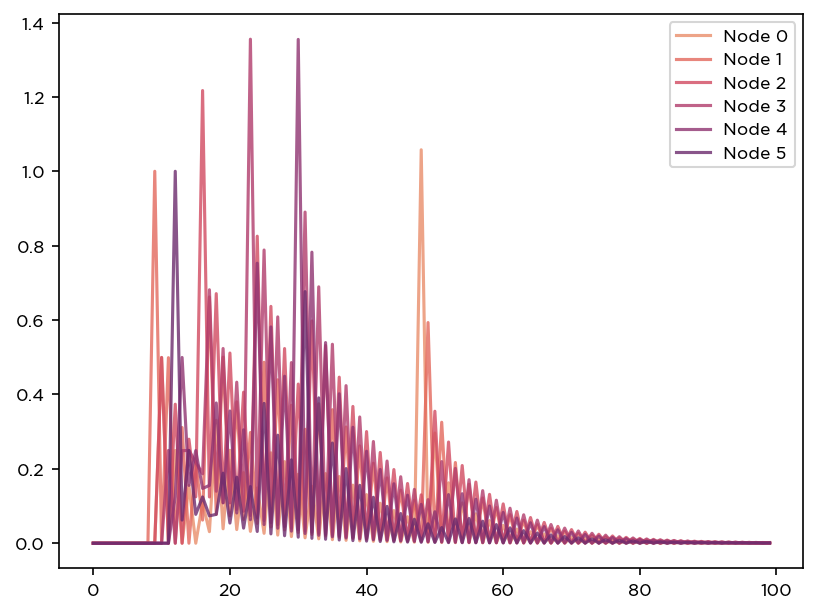

In [85]:
plt.figure(dpi=150)
with sns.color_palette("flare",n_colors=example_input.shape[0]):
    plt.plot(symmetric_chain_dynamics.T,alpha=0.8)
plt.legend(['Node 0','Node 1','Node 2','Node 3','Node 4','Node 5'])

In [86]:
cchain= communicability_bin(chain)
cchain[np.diag_indices_from(cchain)] = 0

ccchain= communicability_wei(closedchain)
ccchain[np.diag_indices_from(cchain)] = 0

csychain= communicability_wei(symmetricchain)
csychain[np.diag_indices_from(cchain)] = 0


In [87]:
lesion_params = {'network': chain, 'input': example_input}
ci_chain = msa.estimate_causal_influences(elements=list(range(len(chain))),
                                        objective_function=lesion_simple_nodes,
                                        objective_function_params=lesion_params,
                                        n_permutations=1_000, n_cores=1)

lesion_params['network'] = closedchain
ci_closed_chain = msa.estimate_causal_influences(elements=list(range(len(chain))),
                                        objective_function=lesion_simple_nodes,
                                        objective_function_params=lesion_params,
                                        n_permutations=1_000, n_cores=1)

lesion_params['network'] = symmetricchain
ci_symmetric_chain = msa.estimate_causal_influences(elements=list(range(len(chain))),
                                        objective_function=lesion_simple_nodes,
                                        objective_function_params=lesion_params,
                                        n_permutations=1_000, n_cores=1)



0it [00:00, ?it/s]

working on node number 0 from 6 nodes.


100%|██████████| 32/32 [00:00<00:00, 22962.83it/s]


working on node number 1 from 6 nodes.


100%|██████████| 32/32 [00:00<00:00, 16430.13it/s]
2it [00:00, 16.40it/s]

working on node number 2 from 6 nodes.


100%|██████████| 32/32 [00:00<00:00, 15881.88it/s]


working on node number 3 from 6 nodes.


100%|██████████| 32/32 [00:00<00:00, 19273.08it/s]
4it [00:00, 16.02it/s]

working on node number 4 from 6 nodes.


100%|██████████| 32/32 [00:00<00:00, 16126.12it/s]


working on node number 5 from 6 nodes.


100%|██████████| 32/32 [00:00<00:00, 15427.33it/s]
6it [00:00, 15.52it/s]
0it [00:00, ?it/s]

working on node number 0 from 6 nodes.


100%|██████████| 32/32 [00:00<00:00, 22806.75it/s]


working on node number 1 from 6 nodes.


100%|██████████| 32/32 [00:00<00:00, 22641.32it/s]
2it [00:00, 16.11it/s]

working on node number 2 from 6 nodes.


100%|██████████| 32/32 [00:00<00:00, 23444.14it/s]


working on node number 3 from 6 nodes.


100%|██████████| 32/32 [00:00<00:00, 18842.87it/s]
4it [00:00, 15.98it/s]

working on node number 4 from 6 nodes.


100%|██████████| 32/32 [00:00<00:00, 11946.39it/s]


working on node number 5 from 6 nodes.


100%|██████████| 32/32 [00:00<00:00, 20074.44it/s]
6it [00:00, 14.76it/s]
0it [00:00, ?it/s]

working on node number 0 from 6 nodes.


100%|██████████| 32/32 [00:00<00:00, 21760.33it/s]


working on node number 1 from 6 nodes.


100%|██████████| 32/32 [00:00<00:00, 19551.02it/s]
2it [00:00, 15.39it/s]

working on node number 2 from 6 nodes.


100%|██████████| 32/32 [00:00<00:00, 21588.83it/s]


working on node number 3 from 6 nodes.


100%|██████████| 32/32 [00:00<00:00, 22557.60it/s]
4it [00:00, 15.57it/s]

working on node number 4 from 6 nodes.


100%|██████████| 32/32 [00:00<00:00, 22519.75it/s]


working on node number 5 from 6 nodes.


100%|██████████| 32/32 [00:00<00:00, 5728.70it/s]
6it [00:00, 14.19it/s]


In [88]:
ci_chain = ci_chain.groupby(level=0).var().fillna(0)
ci_closed_chain = ci_closed_chain.groupby(level=0).var().fillna(0)
ci_symmetric_chain = ci_symmetric_chain.groupby(level=0).var().fillna(0)

In [89]:
chain_mask = np.where(cchain!=0,1,0)
closedchain_mask = np.where(ccchain!=0,1,0)
symmetricchain_mask = np.where(csychain!=0,1,0)

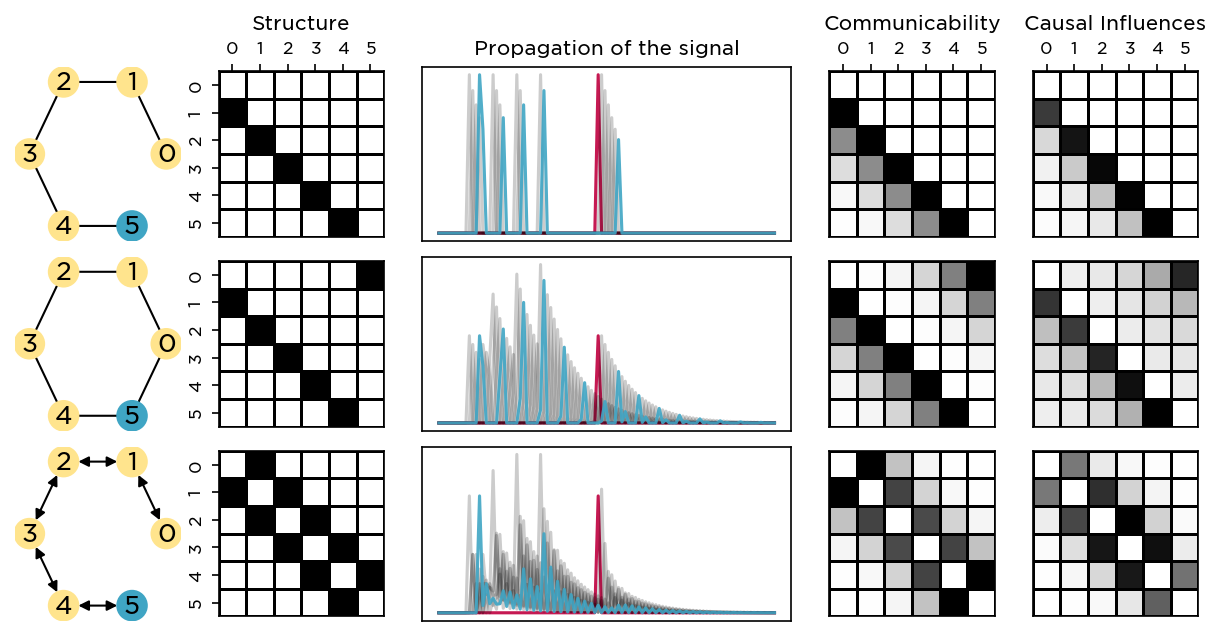

In [90]:
fig,axes = plt.subplot_mosaic([['A','X','B', 'B','CX','CIX'],
                               ['C','Y','D', 'D','CY','CIY'],
                               ['E','Z','F', 'F','CZ','CIZ']],figsize=(8,4.2),dpi=150)

#===================================== STRUCTURE
sns.heatmap(chain,
            square=True,
            cmap='binary',cbar=False,ax=axes['X'],linewidths=0.5, linecolor='k')

sns.heatmap(closedchain,
            square=True,
            cmap='binary',cbar=False,ax=axes['Y'],linewidths=0.5, linecolor='k')

sns.heatmap(symmetricchain,
            square=True,
            cmap='binary',cbar=False,ax=axes['Z'],linewidths=0.5, linecolor='k')
#===================================== COMMUNICABILITY
sns.heatmap(cchain,
            square=True,
            cmap='binary',cbar=False,ax=axes['CX'],linewidths=0.5, linecolor='k')

sns.heatmap(ccchain,
            square=True,
            cmap='binary',cbar=False,ax=axes['CY'],linewidths=0.5, linecolor='k')

sns.heatmap(csychain,
            square=True,
            cmap='binary',cbar=False,ax=axes['CZ'],linewidths=0.5, linecolor='k')
#===================================== CAUSAL INFLUENCE
sns.heatmap(ci_chain*chain_mask,
            square=True,
            cmap='binary',cbar=False,ax=axes['CIX'],linewidths=0.5, linecolor='k')

sns.heatmap(ci_closed_chain*closedchain_mask,
            square=True,
            cmap='binary',cbar=False,ax=axes['CIY'],linewidths=0.5, linecolor='k')

sns.heatmap(ci_symmetric_chain*symmetricchain_mask,
            square=True,
            cmap='binary',cbar=False,ax=axes['CIZ'],linewidths=0.5, linecolor='k')


node_colors=['#FFE48D','#FFE48D','#FFE48D','#FFE48D','#FFE48D','#3FA5C4']
nx.draw_circular(nx.from_numpy_array(chain),ax=axes['A'],
                 arrows=True,node_size=200,node_color=node_colors,with_labels=True)
nx.draw_circular(nx.from_numpy_array(closedchain),ax=axes['C'],
                 arrows=True,node_size=200,node_color=node_colors,with_labels=True)
nx.draw_circular(nx.from_numpy_array(symmetricchain),ax=axes['E'],
                 arrows=True,node_size=200,node_color=node_colors,arrowstyle='<|-|>',with_labels=True)
for ax in ['B','D','F']:
    axes[ax].plot(example_input[0],c=my_colors[-1],alpha=0.9)

    axes[ax].yaxis.set_visible(False)

for ax in ['B','C','D','Y','Z']:
    axes[ax].xaxis.set_visible(False)
for i in range(len(chain)):
    if i < len(chain)-1:
        axes['B'].plot(simple_chain_dynamics.T[:,i],c='k',alpha=0.2)
    else:
        axes['B'].plot(simple_chain_dynamics.T[:,i],c=my_colors[1],alpha=(0.9))

for i in range(len(chain)):
    if i < len(chain)-1:
        axes['D'].plot(closed_chain_dynamics.T[:,i],c='k',alpha=0.2)
    else:
        axes['D'].plot(closed_chain_dynamics.T[:,i],c=my_colors[1],alpha=(0.9))

for i in range(len(chain)):
        if i < len(chain)-1:
            axes['F'].plot(symmetric_chain_dynamics.T[:,i],c='k',alpha=0.2)
        else:
            axes['F'].plot(symmetric_chain_dynamics.T[:,i],c=my_colors[1],alpha=(0.9))

axes['B'].title.set_text('Propagation of the signal')
axes['X'].title.set_text('Structure')
axes['CX'].title.set_text('Communicability')
axes['CIX'].title.set_text('Causal Influences')

axes['B'].yaxis.tick_right()

for ax in ['X','CX','CIX']:
    axes[ax].xaxis.tick_top()
for ax in ['CY','CZ','CIY','CIZ','F']:
    axes[ax].xaxis.set_visible(False)

for ax in ['CX','CY','CZ','CIX','CIY','CIZ']:
    axes[ax].yaxis.set_visible(False)

for ax in axes:
    axes[ax].spines['right'].set_visible(True)
    axes[ax].spines['top'].set_visible(True)
    axes[ax].spines['bottom'].set_visible(True)
    axes[ax].spines['left'].set_visible(True)
fig.tight_layout(pad=0.5)

#plt.savefig(f"chain_propagation.pdf",dpi=600,bbox_inches='tight')

In [91]:
netneurotools.datasets.available_connectomes()

['celegans',
 'drosophila',
 'human_func_scale033',
 'human_func_scale060',
 'human_func_scale125',
 'human_func_scale250',
 'human_func_scale500',
 'human_struct_scale033',
 'human_struct_scale060',
 'human_struct_scale125',
 'human_struct_scale250',
 'human_struct_scale500',
 'macaque_markov',
 'macaque_modha',
 'mouse',
 'rat']

In [92]:
human = netneurotools.datasets.fetch_connectome('human_struct_scale125')

In [93]:
check_symmetric(human['conn'])

True

In [94]:
connectivity = spectral_normalization(0.9,human['conn'])
n_neurons = len(connectivity)
communication_mask = np.where(communicability_wei(connectivity)!=0,1,0)
chuman = normer(communicability_wei(connectivity))

In [95]:
rng = np.random.default_rng(seed=SEED)
timesteps = 100
noise_strength = 0.5

noise = rng.normal(0,noise_strength,(n_neurons,timesteps))

#input = event_maker(len(connectivity),timesteps)
input = noise
simple_human_dynamics = simple_linear_dynamical_system(connectivity,input)

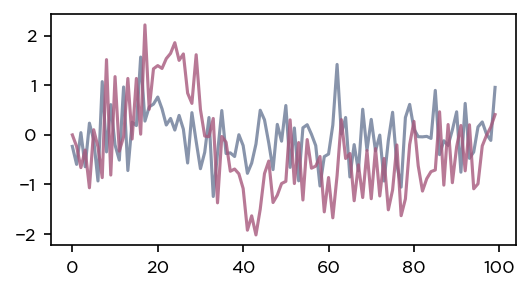

In [96]:
plt.figure(figsize=(4,2),dpi=150)
plt.plot(input[-1],alpha=0.6,color='#394D73')
plt.plot(simple_human_dynamics[-1],alpha=0.8,color='#A6587C');


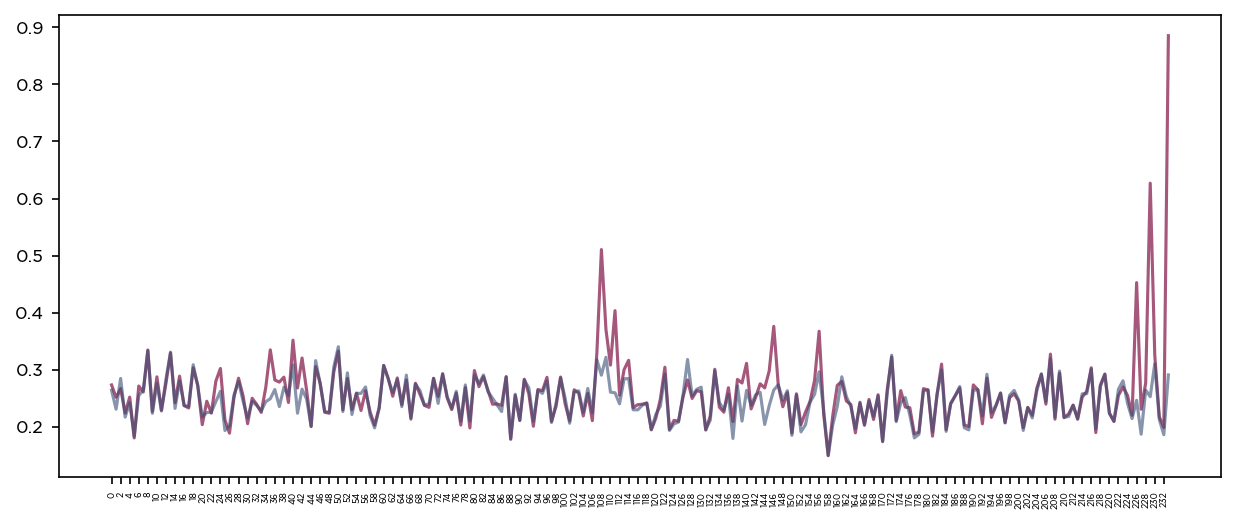

In [97]:
plt.figure(figsize=(10,4),dpi=150)
plt.plot(simple_human_dynamics.var(axis=1),color = '#A6587C')
plt.plot(input.var(axis=1),alpha=0.6,color='#394D73');
plt.xticks(np.arange(0,len(connectivity),2),rotation=90,fontsize=4);

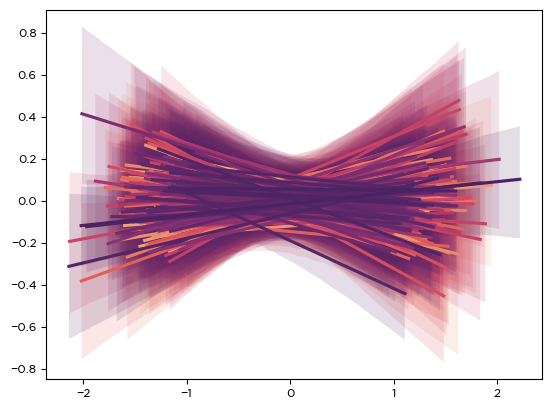

In [98]:
warnings.filterwarnings("ignore")

with sns.color_palette("flare",n_colors=len(simple_human_dynamics)):
    for node in range(len(simple_human_dynamics)):
        sns.regplot(simple_human_dynamics[node],input[node],scatter=False)


In [99]:
from scipy.stats import pearsonr

In [100]:
input_output_similarity = []
for node in range(len(simple_human_dynamics)):
    input_output_similarity.append(pearsonr(simple_human_dynamics[node],input[node])[0])

(array([ 3., 12., 22., 45., 52., 44., 28., 19.,  8.,  1.]),
 array([-0.2732394 , -0.21832815, -0.16341691, -0.10850566, -0.05359441,
         0.00131684,  0.05622809,  0.11113934,  0.16605058,  0.22096183,
         0.27587308]),
 <BarContainer object of 10 artists>)

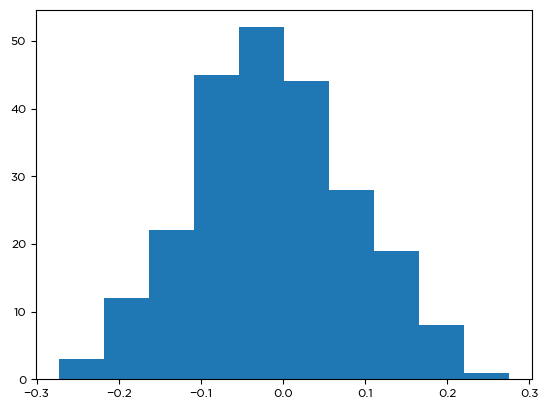

In [101]:
plt.hist(input_output_similarity)

<AxesSubplot:>

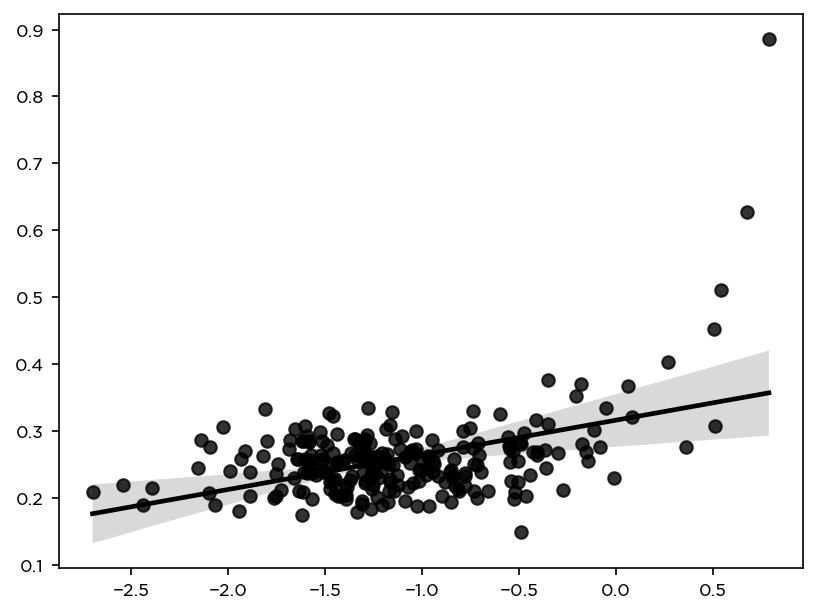

In [102]:
plt.figure(dpi=150)
sns.regplot(np.log(connectivity.sum(axis=1)),simple_human_dynamics.var(axis=1),color='k')

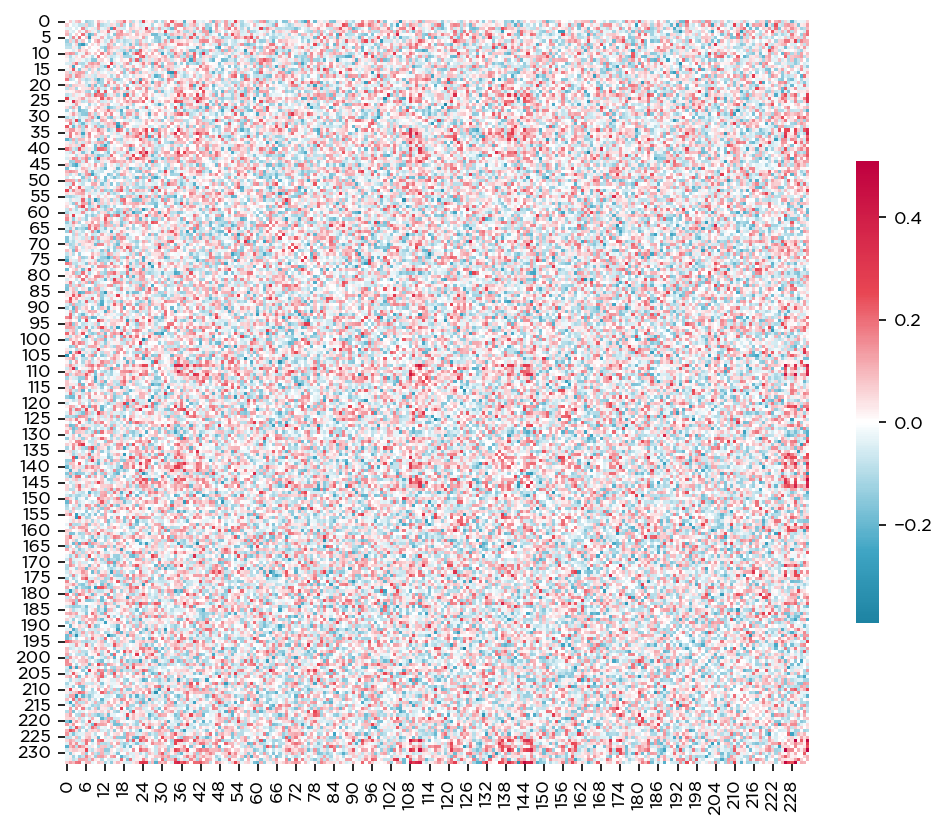

In [103]:
plt.figure(figsize=(8,8),dpi=150)
fc = np.corrcoef(simple_human_dynamics)
np.fill_diagonal(fc,0.)
sns.heatmap(fc,square=True,center=0,
            cmap=colormap,cbar_kws={"shrink": .5},linewidths=0., linecolor='k');

In [104]:
plt.hist(fc.flatten(),bins=100);

In [105]:
n_trials = 25
input_tensor = rng.normal(0,noise_strength,(n_neurons,timesteps,n_trials))
all_trials = np.zeros((len(connectivity),len(connectivity),n_trials))
lesion_params = {'network': connectivity}

In [106]:
# for trial in range(n_trials):
#     lesion_params['input'] = input_tensor[:,:,trial]
#     ci_mat = msa.estimate_causal_influences(elements=list(range(n_neurons)),
#                                             objective_function=lesion_simple_nodes,
#                                             objective_function_params=lesion_params,
#                                             n_permutations=1_000, 
#                                             n_cores=50,
#                                             parallelize_over_games=True,
#                                             permutation_seed = trial)
#     ci_mat.to_pickle(f'ci_mat_{len(connectivity)}_{trial}.pickle')
#     ci_human = ci_mat.groupby(level=0).var().fillna(0)

# On the server:
#    takes around 90 minutes for human_struct_scale125
#    90*25=38h

In [107]:
for trial in range(n_trials):
    temp = pd.read_pickle(f'results/ci_mat_{len(connectivity)}_{trial}.pickle').groupby(level=0).var().fillna(0)
    all_trials[:,:,trial] = temp

In [108]:
averaged_ci = all_trials.mean(axis=2)
averaged_ci = pd.DataFrame(averaged_ci)

In [109]:
input_contribution = simple_human_dynamics.var(axis=1) - averaged_ci.sum(axis=1)

In [110]:
# lesion_params = {'network': connectivity, 'input': input}
# ci_mat = msa.estimate_causal_influences(elements=list(range(n_neurons)),
#                                         objective_function=lesion_simple_nodes,
#                                         objective_function_params=lesion_params,
#                                         n_permutations=1_000, 
#                                         n_cores=-1,
#                                         parallelize_over_games=True)

# takes around 190 minutes for human_struct_scale125
# takes around 30 minutes for human_struct_scale060
# takes around 10 minutes for human_struct_scale033

In [111]:
# plt.figure(dpi=150)
# for i in range(n_neurons):
#     plt.plot(ci_mat[i][2],'k',alpha=0.3) # influence on the node
#     plt.plot(ci_mat[2][i],'r',alpha=0.3) # influenced by the node

In [112]:
normalized_ci = normer(averaged_ci*communication_mask)
diff = normalized_ci - chuman
diff = threshold(1,diff)
boths_outgoing = make_influence_ratio(diff,axis=0)
boths_incoming = make_influence_ratio(diff,axis=1)

In [137]:
type(boths_incoming)

pandas.core.series.Series

In [113]:
plt.plot(input_contribution)


In [114]:
cp_labels = np.load('coreness.npy',allow_pickle=True).item()


In [115]:
lhannot = '/home/kayson/ownCloud/communication-and-causation/annot/lh.lausanne2018.scale3.annot'
rhannot = '/home/kayson/ownCloud/communication-and-causation/annot/rh.lausanne2018.scale3.annot'
mlab.init_notebook('png',1024,1024)

Notebook initialized with png backend.



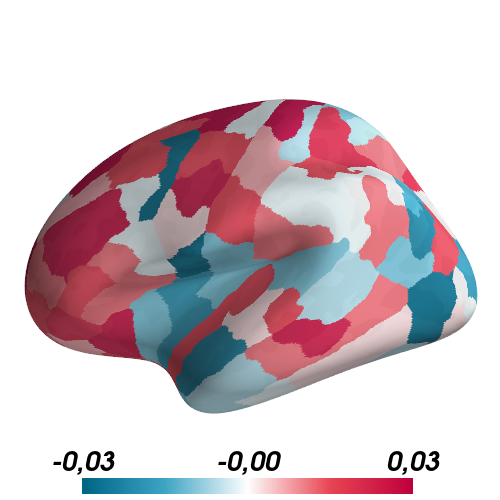


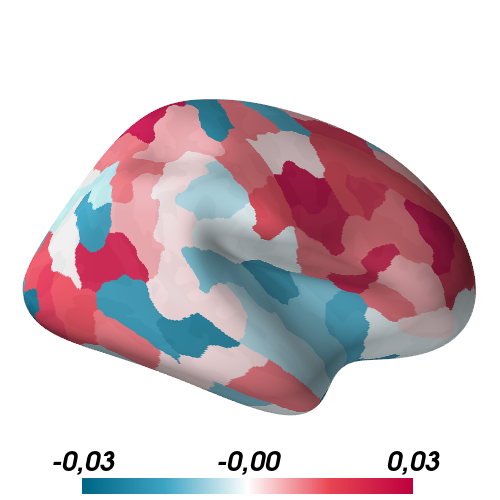


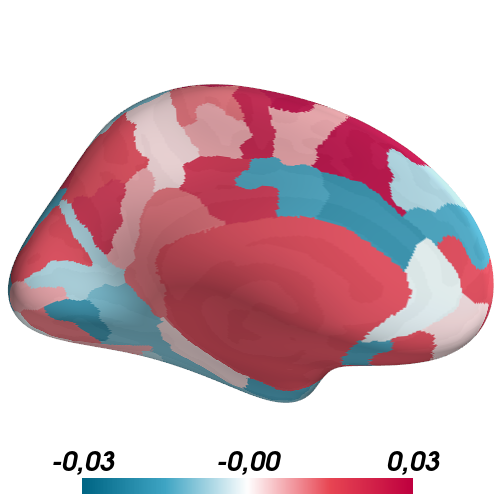


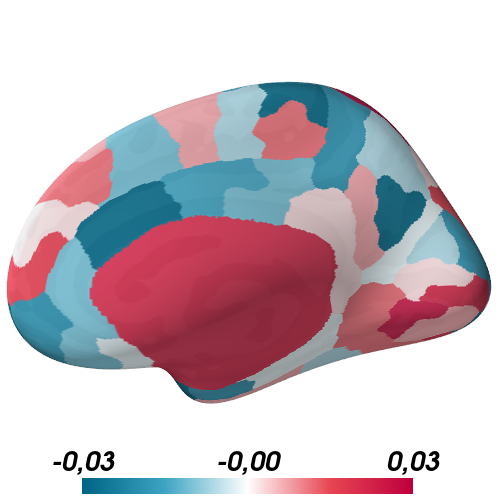

In [116]:
plot_fsaverage(boths_outgoing,lhannot=lhannot,rhannot=rhannot,order='rl'
               ,**{'colormap':colormap,'surf':'inflated','views':['lat','med'],'cortex':'low_contrast'})


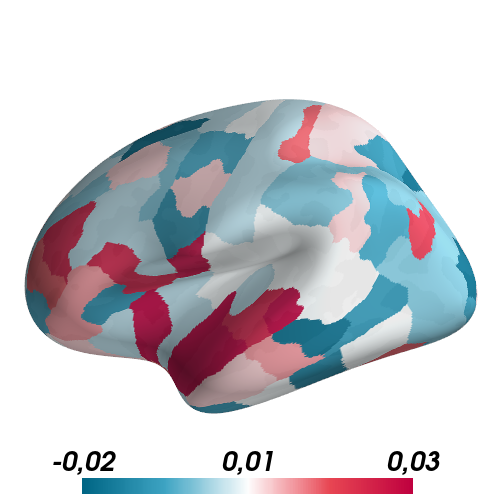


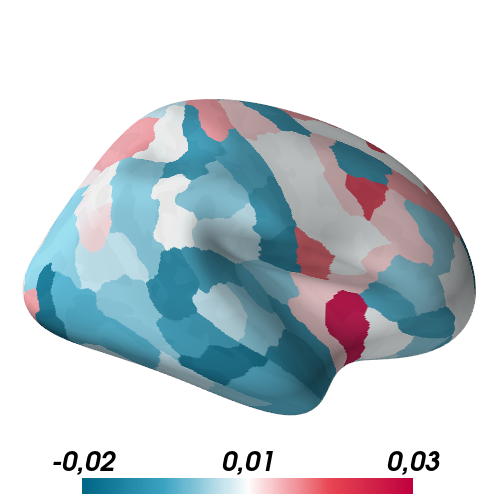


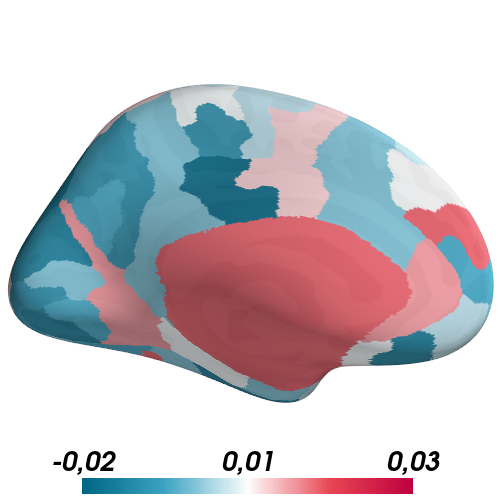


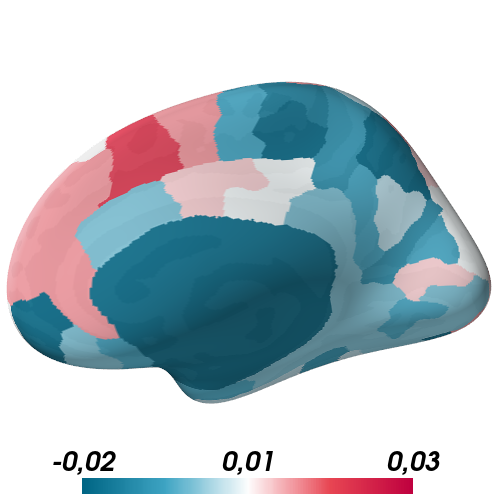

In [117]:
plot_fsaverage(boths_incoming,lhannot=lhannot,rhannot=rhannot,order='rl'
               ,**{'colormap':colormap,'surf':'inflated','views':['lat','med'],'cortex':'low_contrast'})
#mlab.savefig('test.png',size=(1024, 1024))

In [132]:
human['coords'][0]

array([ 17.81672776,  19.67910696, -22.42452516])

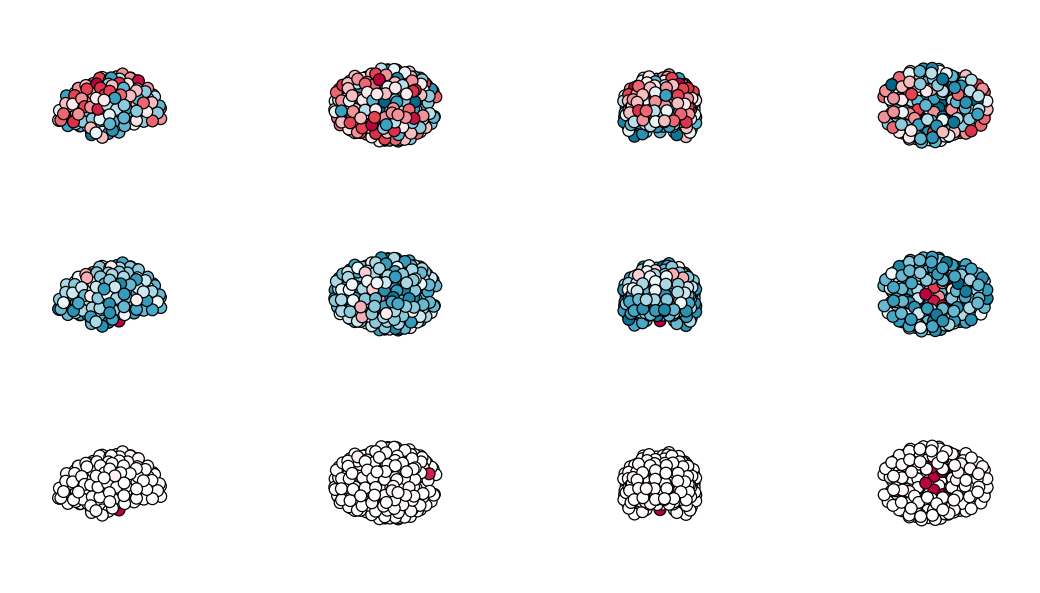

In [118]:
scatter_kw = dict(alpha=1,linewidth=0.3, edgecolor='k')
size=8
fig,axes = plt.subplot_mosaic([['A','B','C','D'],
                               ['E','F','G','H'],
                               ['L','M','N','O'],],figsize=(4,2),subplot_kw=dict(projection='3d'),dpi=300)
brain_plotter(boths_outgoing,human['coords'],axes['A'],view=sagittal,size=size,cmap=colormap,scatter_kwargs=scatter_kw)
brain_plotter(boths_outgoing,human['coords'],axes['B'],view=axial,size=size,cmap=colormap,scatter_kwargs=scatter_kw)
brain_plotter(boths_outgoing,human['coords'],axes['C'],view=coronal,size=size,cmap=colormap,scatter_kwargs=scatter_kw)
brain_plotter(boths_outgoing,human['coords'],axes['D'],view=bottom,size=size,cmap=colormap,scatter_kwargs=scatter_kw)


brain_plotter(boths_incoming,human['coords'],axes['E'],view=sagittal,size=size,cmap=colormap,scatter_kwargs=scatter_kw)
brain_plotter(boths_incoming,human['coords'],axes['F'],view=axial,size=size,cmap=colormap,scatter_kwargs=scatter_kw)
brain_plotter(boths_incoming,human['coords'],axes['G'],view=coronal,size=size,cmap=colormap,scatter_kwargs=scatter_kw)
brain_plotter(boths_incoming,human['coords'],axes['H'],view=bottom,size=size,cmap=colormap,scatter_kwargs=scatter_kw)

brain_plotter(list(cp_labels.values()),human['coords'],axes['L'],view=sagittal,size=size,cmap=redmap,scatter_kwargs=scatter_kw)
brain_plotter(list(cp_labels.values()),human['coords'],axes['M'],view=axial,size=size,cmap=redmap,scatter_kwargs=scatter_kw)
brain_plotter(list(cp_labels.values()),human['coords'],axes['N'],view=coronal,size=size,cmap=redmap,scatter_kwargs=scatter_kw)
brain_plotter(list(cp_labels.values()),human['coords'],axes['O'],view=bottom,size=size,cmap=redmap,scatter_kwargs=scatter_kw)
fig.tight_layout(pad=1)

In [119]:
influencers = normer(threshold(1,normalized_ci).sum())
followers = normer(threshold(1,normalized_ci).sum(axis=1))
influence_ratio = influencers - followers


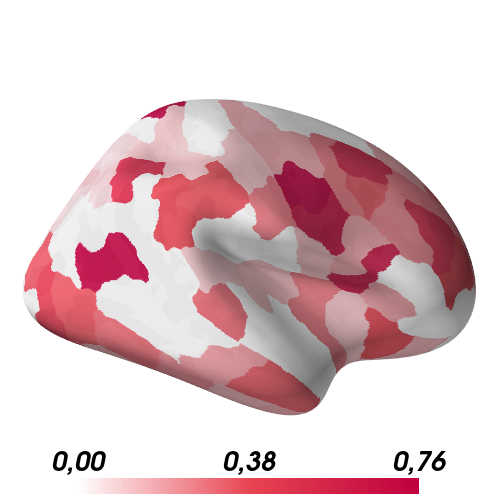


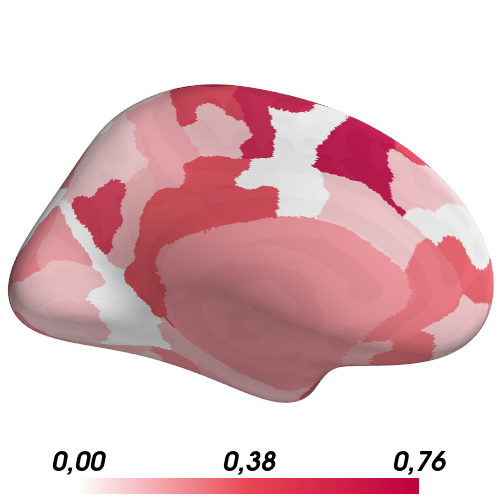


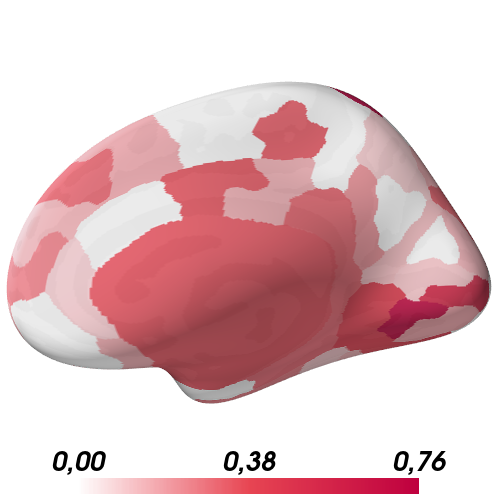

In [120]:
plot_fsaverage(influencers,lhannot=lhannot,rhannot=rhannot,order='rl'
               ,**{'colormap':redmap,'surf':'inflated','views':['lat','med'],'cortex':'low_contrast'})

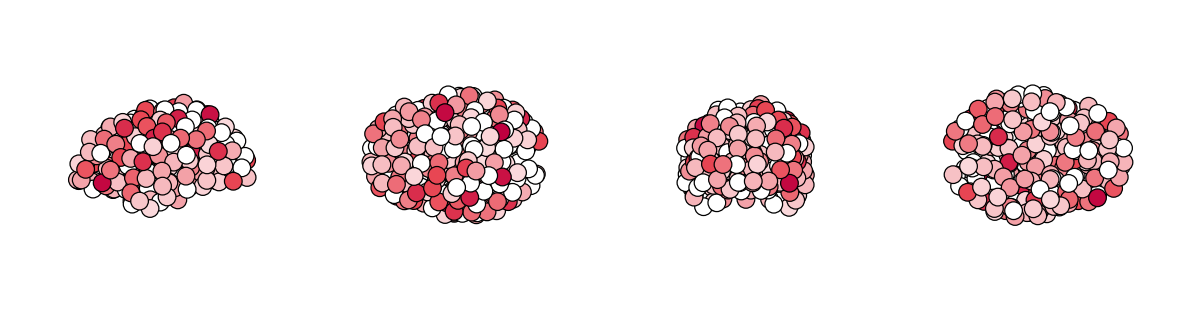

In [121]:
scatter_kw = dict(alpha=1,linewidth=0.3, edgecolor='k')
size=18
fig,axes = plt.subplot_mosaic([['A','B','C','D']],figsize=(4,2),subplot_kw=dict(projection='3d'),dpi=300)
brain_plotter(influencers,human['coords'],axes['A'],view=sagittal,size=size,cmap=redmap,scatter_kwargs=scatter_kw)
brain_plotter(influencers,human['coords'],axes['B'],view=axial,size=size,cmap=redmap,scatter_kwargs=scatter_kw)
brain_plotter(influencers,human['coords'],axes['C'],view=coronal,size=size,cmap=redmap,scatter_kwargs=scatter_kw)
brain_plotter(influencers,human['coords'],axes['D'],view=bottom,size=size,cmap=redmap,scatter_kwargs=scatter_kw)
fig.tight_layout(pad=1)

In [122]:
log_ci = np.abs(np.nan_to_num(np.log(normalized_ci),neginf=0))
log_comm = np.abs(np.nan_to_num(np.log(chuman),neginf=0))
log_sc = np.abs(np.nan_to_num(np.log(normer(connectivity)),neginf=0))

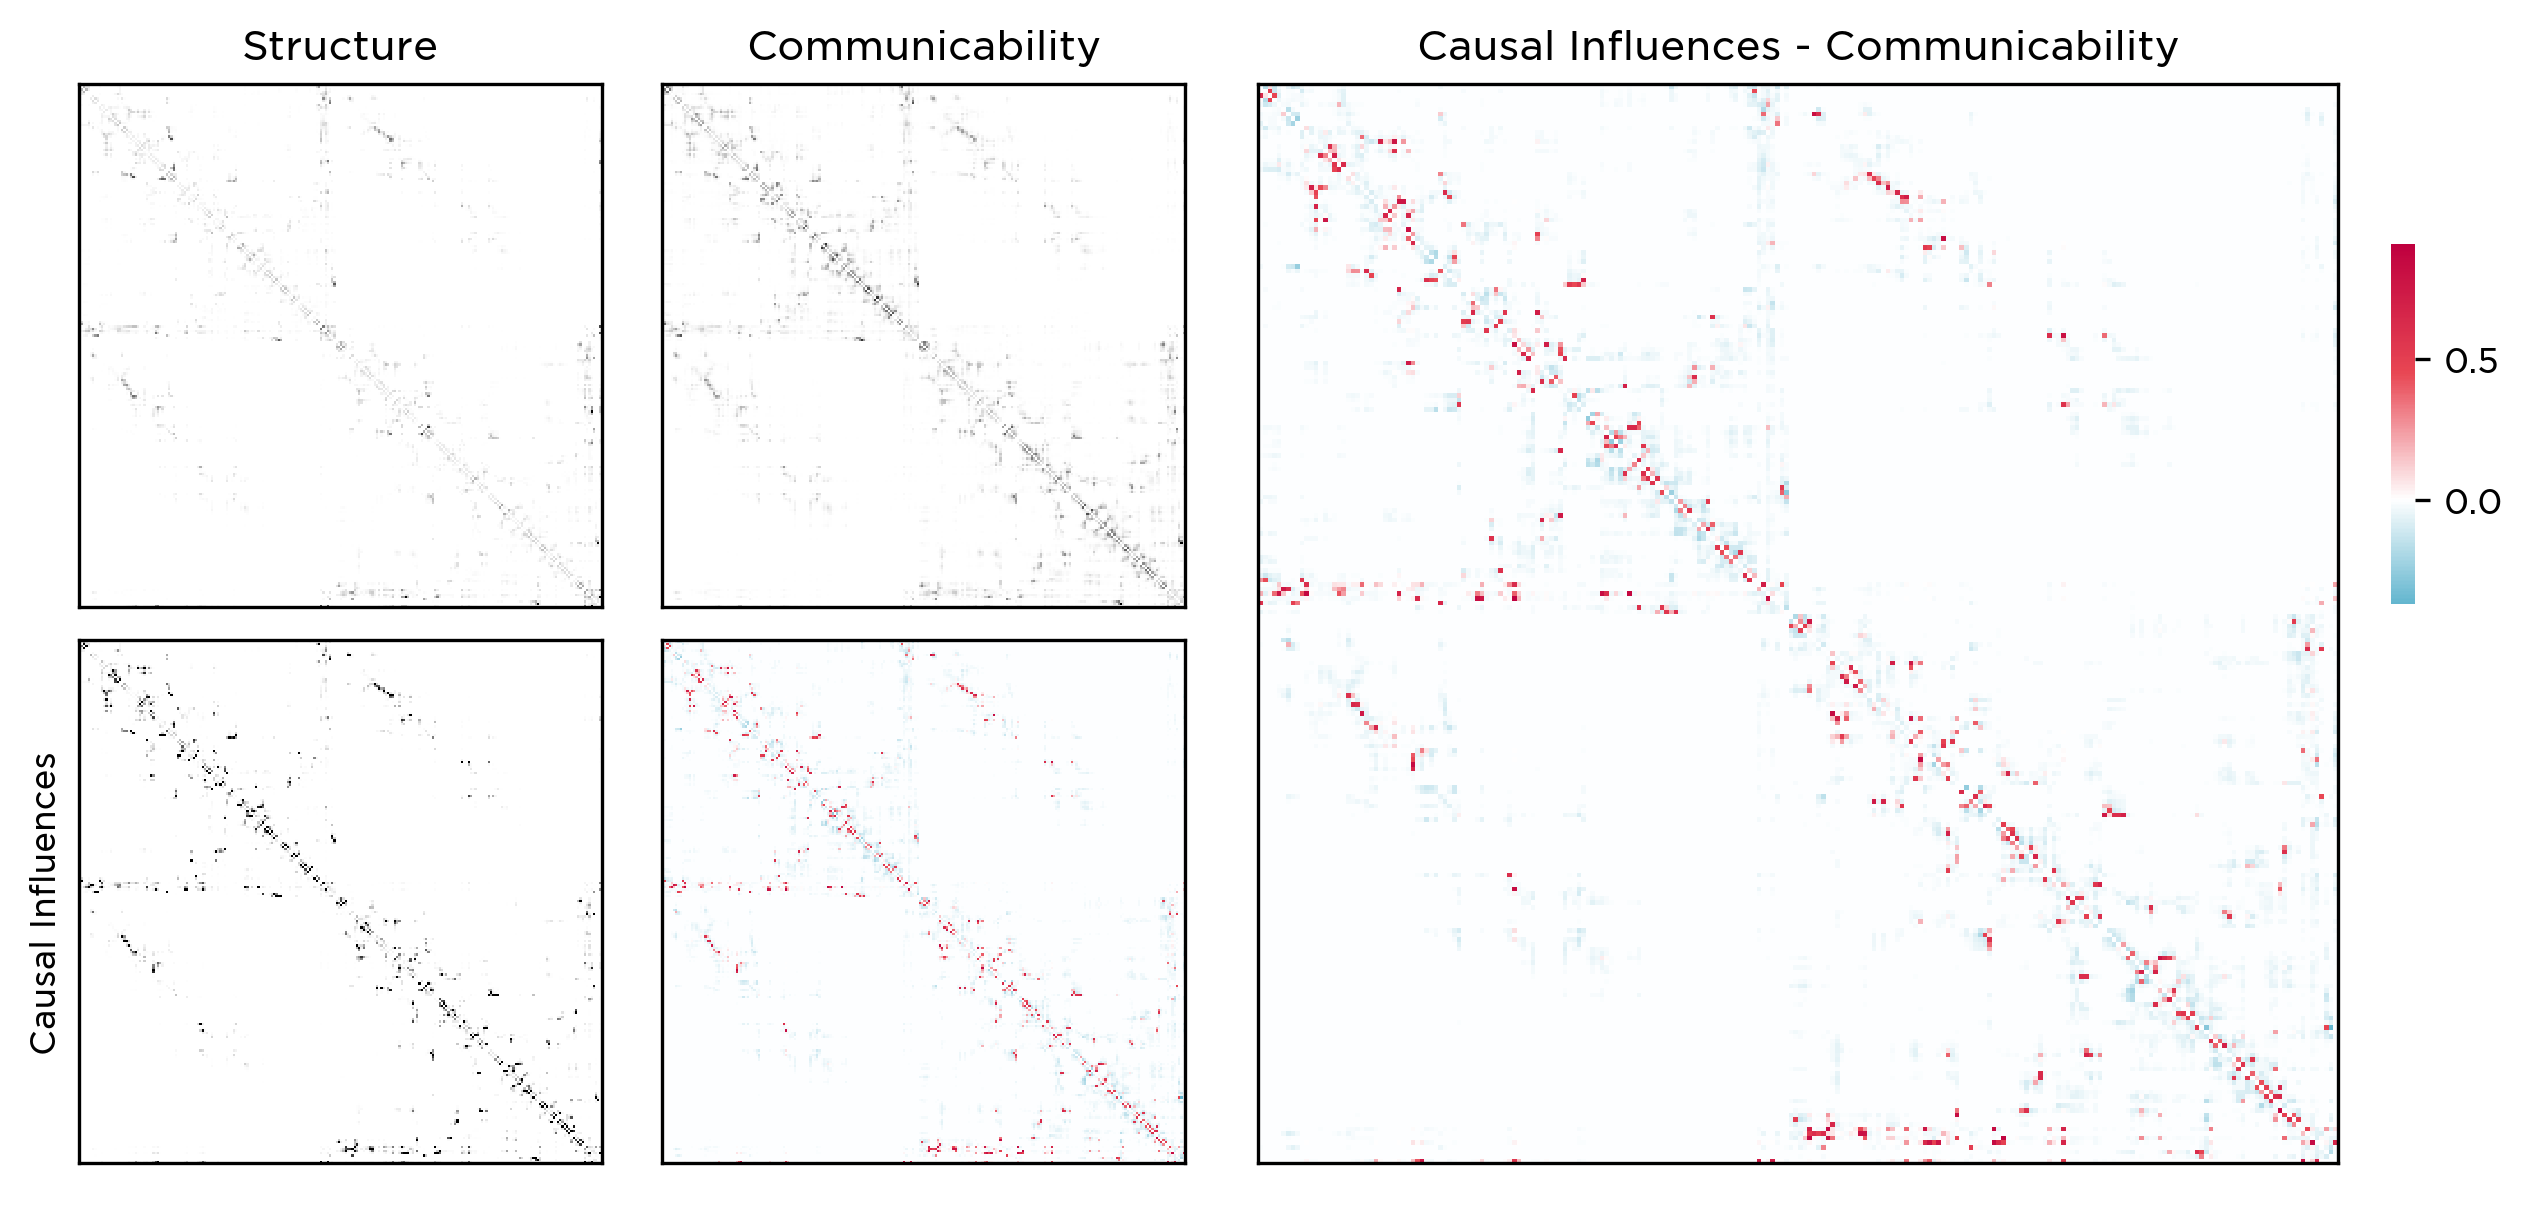

In [123]:
fig,axes = plt.subplot_mosaic([['A','CA','Z','Z'],
                               ['CI','DI','Z','Z']],figsize=(8,4),dpi=300)
cbar_ax = fig.add_axes([1, .5, .01, .3])

sns.heatmap(normer(connectivity),square=True,xticklabels=False,yticklabels=False,
            cmap='binary',cbar=False,ax=axes['A'],linewidths=0, linecolor='k')
sns.heatmap(chuman,square=True,xticklabels=False,yticklabels=False,
            cmap='binary',cbar=False,ax=axes['CA'],linewidths=0, linecolor='k')

sns.heatmap(normalized_ci*communication_mask,square=True,xticklabels=False,yticklabels=False,
            cmap='binary',cbar=False,ax=axes['CI'],linewidths=0, linecolor='k')
sns.heatmap((normalized_ci - chuman),square=True,xticklabels=False,yticklabels=False,center=0,
            cmap=colormap,cbar=False,ax=axes['DI'],linewidths=0, linecolor='k')
sns.heatmap((normalized_ci - chuman),square=True,xticklabels=False,yticklabels=False,center=0,
            cmap=colormap,cbar_ax=cbar_ax,ax=axes['Z'],linewidths=0.0)
for ax in axes:
    axes[ax].spines['right'].set_visible(True)
    axes[ax].spines['top'].set_visible(True)
    axes[ax].spines['bottom'].set_visible(True)
    axes[ax].spines['left'].set_visible(True)

#axes['B'].title.set_text('Propagation of the signal through the human connectome')
axes['A'].title.set_text('Structure')
axes['CA'].title.set_text('Communicability')
axes['Z'].title.set_text('Causal Influences - Communicability')
axes['CI'].set_ylabel("Causal Influences")

fig.tight_layout(pad=1)
#plt.savefig(f"human_propagation.pdf",dpi=600,bbox_inches='tight')

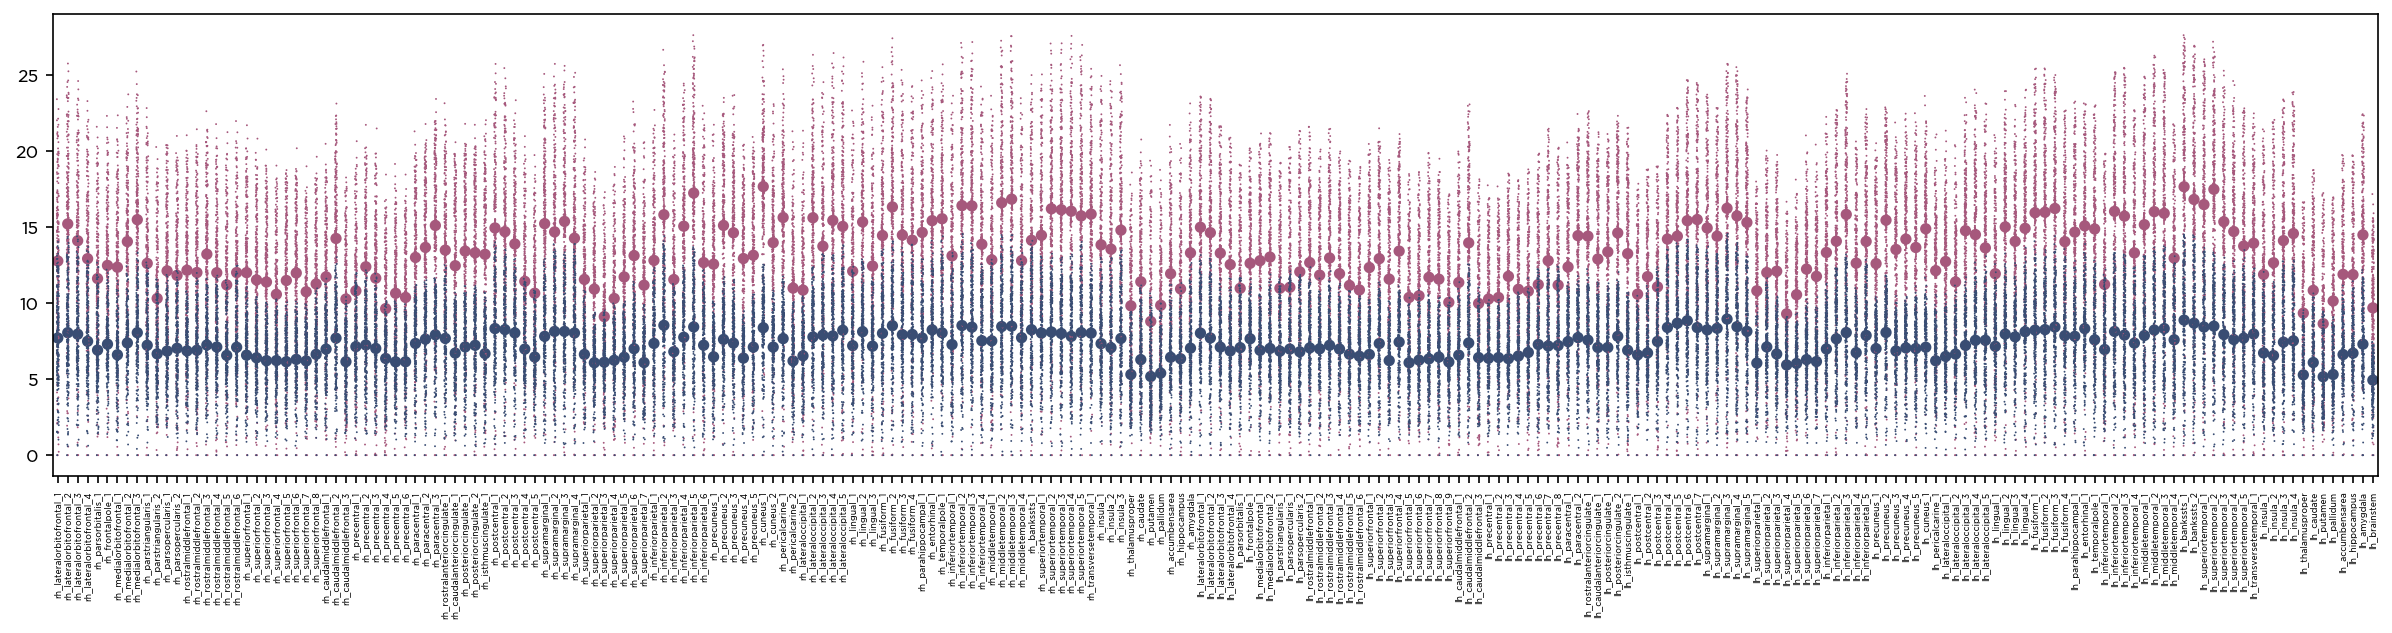

In [124]:
plt.figure(figsize=(20,4),dpi=150)
sns.pointplot(data=log_ci,color='#A6587C',label='Causal Influence',join=False,markers='.',errwidth=0.8) #red
sns.pointplot(data=log_comm,color='#394D73',label='Communicability',join=False,markers='.',errwidth=0.8)

sns.stripplot(data=log_ci,color='#A6587C',label='Causal Influence',size=0.9) #red
sns.stripplot(data=log_comm,color='#394D73',label='Communicability',size=0.9)
plt.xticks(ticks = [i for i,_ in enumerate(human.labels)],labels=human.labels,rotation=90,fontsize=4);

(-0.5, 28.5)

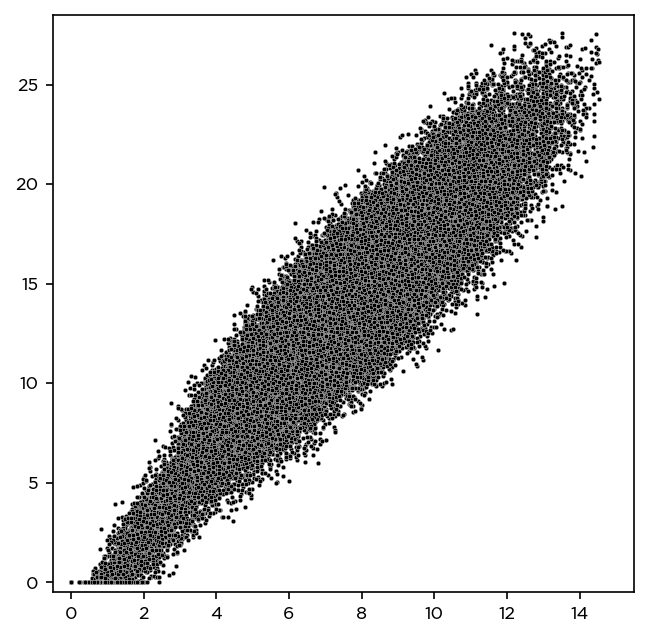

In [125]:
plt.figure(figsize=(5,5),dpi=150)
sns.scatterplot(x=log_comm.flatten(),y=log_ci.flatten(),color='k',s=5)
#sns.scatterplot(x=log_sc.flatten()[log_sc.flatten()!=0],y=log_ci.flatten()[log_sc.flatten()!=0],color='#394D73',s=5)
plt.xlim(-0.5,15.5)
plt.ylim(-0.5,28.5)

<AxesSubplot:>

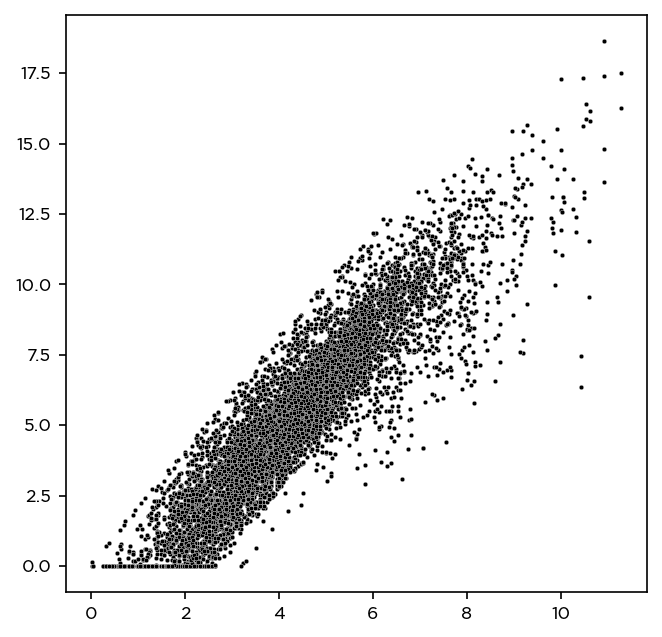

In [126]:
plt.figure(figsize=(5,5),dpi=150)
sns.scatterplot(x=log_sc.flatten()[log_sc.flatten()!=0],y=log_ci.flatten()[log_sc.flatten()!=0],color='k',s=5)

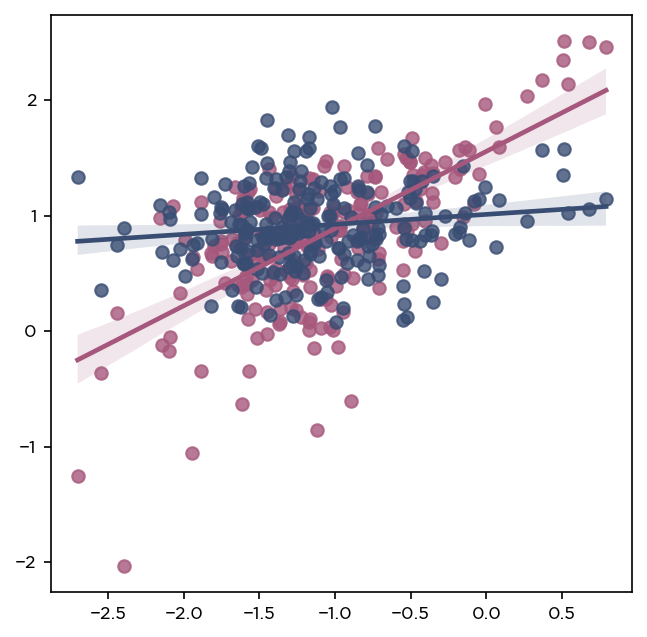

In [127]:
plt.figure(figsize=(5,5),dpi=150)
sns.regplot(np.log(connectivity.sum(axis=1)),np.log(normalized_ci.sum(axis=1)),color='#A6587C') #purple, in-degree
sns.regplot(np.log(connectivity.sum(axis=0)),np.log(normalized_ci.sum(axis=0)),color='#394D73');

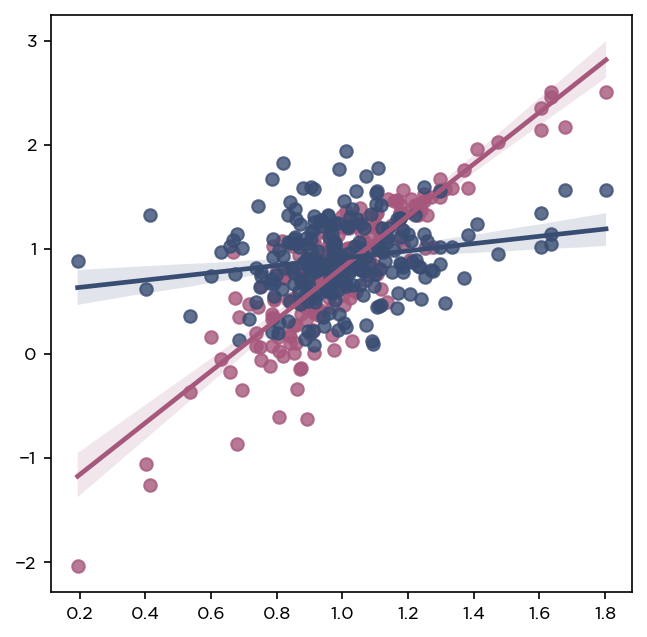

In [128]:
plt.figure(figsize=(5,5),dpi=150)
sns.regplot(np.log(chuman.sum(axis=1)),np.log(normalized_ci.sum(axis=1)),color='#A6587C') #purple, in-degree
sns.regplot(np.log(chuman.sum(axis=0)),np.log(normalized_ci.sum(axis=0)),color='#394D73');

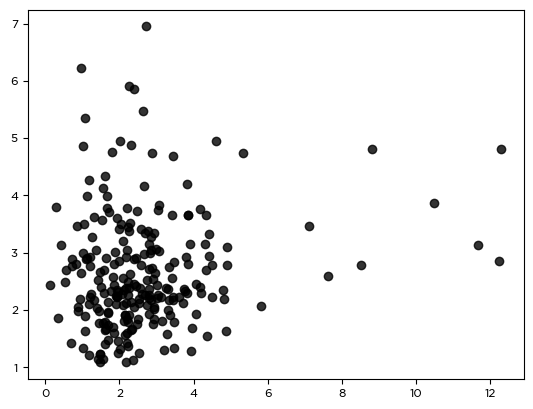

In [129]:
sns.regplot(normalized_ci.sum(axis=1),normalized_ci.sum(axis=0),color='k',fit_reg=False);